In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pyccl as ccl
import os.path 
import math
from os.path import exists as file_exists
import scipy.special

In [2]:
choose_file = []
for i in range(0,6):
    for j in range(0,12):
        for filename in os.listdir('/mnt/zfsusers/anyabua/FermiX'):
            if filename == "W_galagam_" + str(i)+"x"+str(j)+".npz":
                choose_file.append(str(filename))
data_files = np.reshape(choose_file,(6,12))

ells = np.load(data_files[0][0])['ells']
all_jackerrors = {f'jkerr{gal}x{gam}': np.squeeze(np.load(data_files[gal][gam])['jack_error']) for gal in range(6) for gam in range(12)} 
all_pcl = {f'galaxy x gamma:{gal}x{gam}': np.squeeze(np.load(data_files[gal][gam])['PCL_fskydivided']) for gal in range(6) for gam in range(12)} 
all_bpw = {f'bpw{gal}x{gam}': np.load(data_files[gal][gam])['bpw'] for gal in range(6) for gam in range(12)} 
all_JKCL = {f'JKCL{gal}x{gam}': np.load(data_files[gal][gam])['JKCL'] for gal in range(6) for gam in range(12)}

In [3]:
z = {}
dndz = {}
for gal in range(0,6):
    z[f'{gal}'], dndz[f'{gal}'] = np.loadtxt(f"dndz_bin{gal}.txt", unpack=True)
    
# ____________________________________________________PRELIMINARIES__________________________________________________________#
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

k_arr = np.geomspace(1e-4,100,256) # no of k arr was originally 256
a = 1./(1+z['3']) 
a_arr = a[::-1]
chi = ccl.comoving_radial_distance(cosmo,a_arr)

Chi = np.zeros((6,150))
for i in range(6):
    Chi[i] = chi
print(Chi.shape)
    
# We will use a mass definition with Delta = 200 times the matter density
hmd_200c = ccl.halos.MassDef200c() 

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200c)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200c)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200c)
    
# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200c)

pk_MxMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pM, prof2=pM,
                                 normprof1=True, normprof2=True,
                                 lk_arr=np.log(k_arr), a_arr=a_arr)
    

(6, 150)


# Signal-to-noise for Decay 

In [4]:
# ___________________________________galaxy_tracer____________________________________________________________________________#

t_g = []
for gal in range(0,6):
    t_gal = ccl.NumberCountsTracer(cosmo, has_rsd = False, dndz=(z[f'{gal}'],dndz[f'{gal}']), bias=(z[f'{gal}'], np.ones_like(z[f'{gal}'])))
    t_g.append(t_gal)
    
galtracer = np.array(t_g)


### gamma ray 

def try_kernel(alpha,z):
        kernel = (1+z)**alpha
        return np.array(kernel)
    
    
kernel_alpha0 = np.zeros((2,6,150))
for gal in range(1,6):
    kernel_alpha0[0,gal] = chi
    kernel_alpha0[1,0,:100] = try_kernel(0,z['0'])
    kernel_alpha0[1,gal] = try_kernel(0,z[f'{gal}'])
    
for gal in range(6):
    GRB_tracer = ccl.Tracer()
    GRB_tracer.add_tracer(cosmo, kernel= (kernel_alpha0[0,gal],kernel_alpha0[1,gal]))
    cl_theory0 = ccl.angular_cl(cosmo, GRB_tracer , t_gal, ells, p_of_k_a = None) # for alpha = 0 
    cl_theorycheck0 = ccl.angular_cl(cosmo,GRB_tracer, t_gal, ells, p_of_k_a = pk_MxMf)
    

print(cl_theory0)
print(cl_theorycheck0)


[0.01636852 0.00990178 0.00625236 0.00447796 0.00336166 0.00267134
 0.00218979 0.00184475 0.00156475 0.00133392 0.00114569 0.00098985
 0.00085957 0.00075016 0.00065643 0.00057531 0.00050403 0.00044074
 0.00038412 0.00033298 0.00028678 0.00024513 0.0002077  0.00017437]
[0.01683376 0.01014314 0.00628304 0.00438156 0.00317982 0.00243827
 0.00192418 0.0015604  0.00126997 0.00103635 0.00085208 0.00070601
 0.00059049 0.00049979 0.00042793 0.00037081 0.00032479 0.00028704
 0.00025535 0.00022778 0.00020309 0.00018033 0.00015889 0.00013851]


In [5]:
kernel_alpha1 = np.zeros((2,6,150))
for gal in range(1,6):
    kernel_alpha1[0,gal] = chi
    kernel_alpha1[1,0,:100] = try_kernel(-1,z['0'])
    kernel_alpha1[1,gal] = try_kernel(-1,z[f'{gal}'])

for gal in range(6):
    GRB_tracer = ccl.Tracer()
    GRB_tracer.add_tracer(cosmo, kernel= (kernel_alpha1[0,gal],kernel_alpha1[1,gal]))
    cl_theory1 = ccl.angular_cl(cosmo, GRB_tracer , t_gal, ells, p_of_k_a = None) 
    cl_theorycheck1 = ccl.angular_cl(cosmo, GRB_tracer, t_gal, ells, p_of_k_a = pk_MxMf)

print(cl_theory1.shape)
print(cl_theorycheck1)

(24,)
[0.01683376 0.01014314 0.00628304 0.00438156 0.00317982 0.00243827
 0.00192418 0.0015604  0.00126997 0.00103635 0.00085208 0.00070601
 0.00059049 0.00049979 0.00042793 0.00037081 0.00032479 0.00028704
 0.00025535 0.00022778 0.00020309 0.00018033 0.00015889 0.00013851]


In [6]:
jkerr = np.array([[all_jackerrors[f'jkerr{g}x{i}'] for i in range(12)] for g in range(6)])
cl_data = np.array([[all_pcl[f'galaxy x gamma:{g}x{i}'] for i in range(12)] for g in range(6)])
print('shape of jk err: ' + str(jkerr.shape))
print('shape of cl dat: ' + str(cl_data.shape))

#for alpha = -1
cl_th1 = np.zeros((6,12,24))
for i in range(6):
    for j in range(12):
        cl_th1[i,j] = cl_theory1

s_squared = 1/np.sum((cl_th1/jkerr)**2, axis = 2)
s = np.sqrt(s_squared)
A = np.sum((cl_th1*cl_data)/(jkerr**2), axis = 2)
sig = A*s_squared
sig_to_noise_alpha1_dec= sig/s

for i in range(6):
    print(min(sig_to_noise_alpha1_dec[i]))

shape of jk err: (6, 12, 24)
shape of cl dat: (6, 12, 24)
-0.9287069542813094
-1.3915559668527255
-0.7516915078769143
-2.2424432568334356
-0.7040737046467351
-0.35817516244532327


# Signal-to-noise for Annihilation

In [7]:
from scipy.special import sici
#Creating a Halo profile that describes Dark matter annihilation in k-space. The DarkMatterAnnihilationProfile is the Fourier
#transform of the NFW profile squared. This is then used to compute the Pk2D(Matter x Dark Matter Annihilation) 
#and compared with the Pk2D (Matter x Matter) obtained from just the standard NFW profile (also in k-space). 
#These are the two competing models for that data points.

#the rho^1 is for decay 
#the rho^2 is for annihilation

class DarkMatterAnnihilationProfile(ccl.halos.HaloProfile):
    def __init__(self,c_M_relation):
        self.cM = c_M_relation
        super().__init__()
        
    def _get_cM(self, cosmo, M, a, mdef=None):
        return self.cM.get_concentration(cosmo, M, a, mdef_other = mdef)
    
    def _fourier(self, cosmo, k , M , a , mass_def):
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)
    
        
        R_M = mass_def.get_radius(cosmo, M_use, a) / a #comoving virial radius
        c_M =self._get_cM(cosmo,M_use,a,mass_def)
    
        R_s = R_M / c_M
        rho0 = M_use / (4 * np.pi * R_s**3)

        q = k_use[None, :] * R_s[:, None]
        
        
        Si_q, Ci_q = sici(q)
        P1 = M_use / (np.log(1 + c_M) - c_M/ (1 + c_M))
        c_M = c_M[:, None]
        Si_oneplusc, Ci_oneplusc = sici((1 + c_M) * q)
        Si_qc, Ci_qc = sici(q*c_M)
        
        A = (rho0 * P1)[:, None] / q
        
        Si1 = Si_oneplusc - Si_q
        Ci1 = Ci_oneplusc - Ci_q
        
        q_half = (1-(q**2)/2)
        q_sixth = (q-(q**3)/6)
        
        Si_term = Si1*(q_half*np.cos(q)+ q_sixth*np.sin(q))
        Ci_term = Ci1*(q_half*np.sin(q)-q_sixth*np.cos(q))
        
        sin_term = np.sin(q*c_M)*((6*(1 + c_M)**2 + 5 + 3*c_M - (q**2)*(1+c_M)**2)/(6*(1 + c_M)**3))
        cos_term = q*np.cos(q*c_M)*(4 + 3*c_M)/(6*(1 + c_M)**2)
      
        prof = A*(Si_qc - Si_term + Ci_term - 2*q/3 + sin_term + cos_term)
     
        
        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
    
        return prof
        
                           

pDM = DarkMatterAnnihilationProfile(cM)


pk_DMxMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pDM, prof2=pM,
                                  normprof1=True, normprof2=True,
                                  lk_arr=np.log(k_arr), a_arr=a_arr)

In [8]:
#alpha = -1
for gal in range(6):
    GRB_tracer = ccl.Tracer()
    GRB_tracer.add_tracer(cosmo, kernel= (kernel_alpha1[0,gal],kernel_alpha1[1,gal])) 
    cl_theory1_ann = ccl.angular_cl(cosmo, GRB_tracer, t_gal, ells, p_of_k_a = pk_DMxMf)
    
cl_th1_ann = np.zeros((6,12,24))
for i in range(6):
    for j in range(12):
        cl_th1_ann[i,j] = cl_theory1_ann

s_squared_ann = 1/np.sum((cl_th1_ann/jkerr)**2, axis = 2)
s_ann = np.sqrt(s_squared_ann)
A_ann = np.sum((cl_th1_ann*cl_data)/(jkerr**2), axis = 2)
sig_ann = A_ann*s_squared_ann
sig_to_noise_alpha1_ann = sig_ann/s_ann

for i in range(6):
    print(min(sig_to_noise_alpha1_ann[i]))

-0.9498781035060943
-1.7515257686817955
-1.1062168846317637
-1.820899331982162
-0.196229827215314
-1.0066234451275584


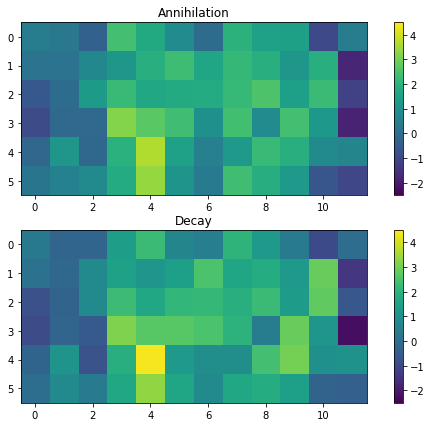

In [9]:
fig, axes = plt.subplots(2, figsize=(10, 7))
to_plot = [sig_to_noise_alpha1_ann,sig_to_noise_alpha1_dec]
titles = ['Annihilation', 'Decay']
for i in range(2):
    ax = axes[i]
    im = ax.imshow(to_plot[i])
    plt.colorbar(im,ax=ax)
    im.set_clim(vmin = -2.5, vmax= 4.5)
    ax.set_title(titles[i])
plt.savefig('newsigtonoise.jpg')

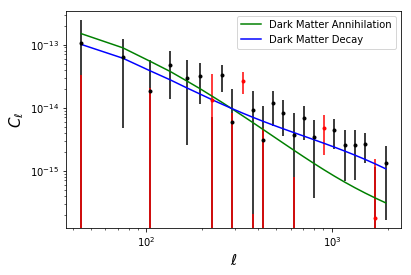

In [11]:
#For the gamma x galaxy with the highest sigma (4sigma) # 

all_pcl_4sigma = all_pcl['galaxy x gamma:4x4']
plt.errorbar(ells,all_pcl_4sigma, yerr = all_jackerrors['jkerr4x4'], fmt = 'k.')
plt.errorbar(ells, -all_pcl_4sigma, yerr = all_jackerrors['jkerr4x4'], fmt = 'r.')
plt.plot(ells, cl_th1_ann[4,4]*sig_ann[4,4], 'g-', label = 'Dark Matter Annihilation')
plt.plot(ells, cl_th1[4,4]*sig[4,4], 'b-', label = 'Dark Matter Decay')
plt.legend()
plt.xlabel('$\ell$', fontsize =15)
plt.ylabel('$C_{\ell}$', fontsize = 15)
plt.loglog()
plt.savefig('4x4clplotfixed.jpg')